In [406]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageFilter

1.

In [420]:
def show(name, n, m, i, title):
    plt.subplot(n,m,i)
    plt.imshow(name, cmap = "gray")
    # plt.imshow(name)
    plt.title(title)
    plt.axis("Off")

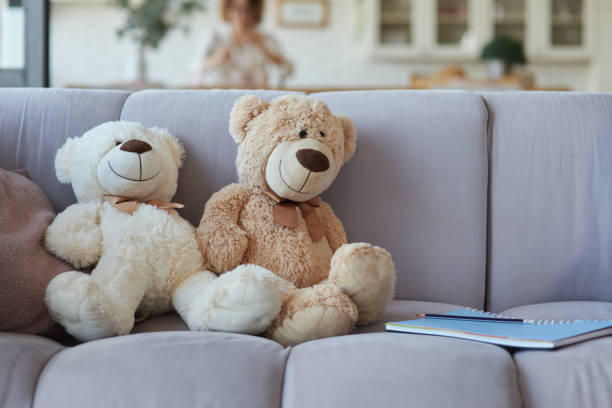

<Figure size 1000x1000 with 0 Axes>

In [421]:
plt.figure(figsize = (10,10))
img = Image.open("teddy_bear.jpg")
img

2.

In [441]:
cam = cv2.VideoCapture(0)
ret, frame = cam.read()
cam.release()
frame_rgb = frame[:, :, [2, 1, 0]]

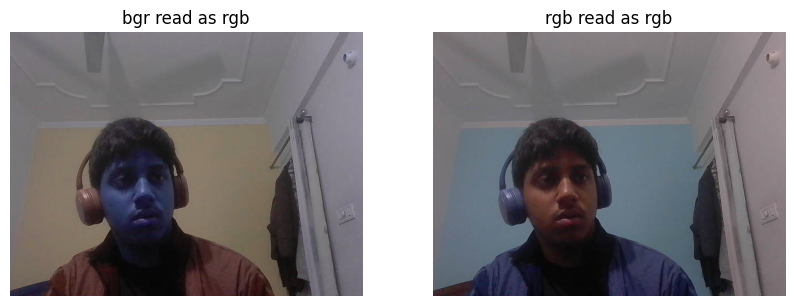

In [442]:
plt.figure(figsize = (10,10))

show(frame, 1,2,1, "bgr read as rgb")
show(frame_rgb, 1,2,2, "rgb read as rgb")

In [443]:
def greymaker(rgb_image):
    if rgb_image.ndim != 3 or rgb_image.shape[2] != 3:
        print("Error: Input image must be a 3D array (height, width, 3).")
        return None

    r, g, b = rgb_image[:,:, 0], rgb_image[:,:, 1], rgb_image[:,:, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray.astype(np.uint8) # Important: Convert to uint8

def thresholding2(img):
    grey = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            grey[i][j] = 0.299 * img[i][j][0] + 0.587 * img[i][j][1] + 0.114 * img[i][j][2]
            if (grey[i][j] > 128): grey[i][j] = 255
            else : grey[i][j] = 0
    return grey

def thresholding16(img):
    grey = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            grey[i][j]= 0.299 * img[i][j][0] + 0.587 * img[i][j][1] + 0.114 * img[i][j][2]
            grey[i][j] = grey[i][j] // 16
    return grey

In [412]:
def sobel_filter(img):
    grey = greymaker(img)
    kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    ky = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Padding to handle borders (important!)
    padded_image = np.pad(grey, pad_width=1, mode='reflect')
    height, width = grey.shape
    grad_x = np.zeros_like(grey, dtype=np.float64) # Use float64 to avoid overflow
    grad_y = np.zeros_like(grey, dtype=np.float64)
    magnitude = np.zeros_like(grey, dtype=np.float64)

    for y in range(height):
        for x in range(width):
            sub_image = padded_image[y:y+3, x:x+3]
            grad_x[y, x] = np.sum(kx * sub_image)
            grad_y[y, x] = np.sum(ky * sub_image)
            magnitude[y, x] = np.sqrt(grad_x[y, x]**2 + grad_y[y, x]**2)

    return magnitude.astype(np.uint8)

In [449]:
def gaussian_blur(image, kernel_size = 5, sigma = 1.0):
    size = int(kernel_size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    kernel = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal

    padded_image = np.pad(image, pad_width=size, mode='reflect')
    height, width = image.shape
    blurred_image = np.zeros_like(image, dtype=np.float64)

    for y in range(height):
        for x in range(width):
            sub_image = padded_image[y:y+kernel_size, x:x+kernel_size]
            blurred_image[y, x] = np.sum(kernel * sub_image)
    return blurred_image.astype(np.uint8)

def sobel_gradients(image):
    kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    ky = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    padded_image = np.pad(image, pad_width=1, mode='reflect')
    height, width = image.shape
    grad_x = np.zeros_like(image, dtype=np.float64)
    grad_y = np.zeros_like(image, dtype=np.float64)
    magnitude = np.zeros_like(image, dtype=np.float64)
    angle = np.zeros_like(image, dtype=np.float64)

    for y in range(height):
        for x in range(width):
            sub_image = padded_image[y:y+3, x:x+3]
            grad_x[y, x] = np.sum(kx * sub_image)
            grad_y[y, x] = np.sum(ky * sub_image)
            magnitude[y, x] = np.sqrt(grad_x[y, x]**2 + grad_y[y, x]**2)
            angle[y, x] = np.arctan2(grad_y[y, x], grad_x[y, x]) * 180. / np.pi #convert to degrees
    return magnitude.astype(np.uint8), angle

def non_max_suppression(magnitude, angle):
    height, width = magnitude.shape
    suppressed = np.zeros_like(magnitude, dtype=np.uint8)
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            current_angle = angle[i, j]
            q = 255
            r = 255

            # angle 0
            if (0 <= current_angle < 22.5) or (157.5 <= current_angle <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]
            # angle 45
            elif (22.5 <= current_angle < 67.5):
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            # angle 90
            elif (67.5 <= current_angle < 112.5):
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            # angle 135
            elif (112.5 <= current_angle < 157.5):
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]

            if (magnitude[i, j] >= q) and (magnitude[i, j] >= r):
                suppressed[i, j] = magnitude[i, j]
            else:
                suppressed[i, j] = 0
    return suppressed

def double_threshold(image, low_threshold_ratio=0.05, high_threshold_ratio=0.09):
    high_threshold = image.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio

    strong_edges = (image >= high_threshold)
    weak_edges = (image >= low_threshold) & (image < high_threshold)

    return strong_edges.astype(np.uint8) * 255, weak_edges.astype(np.uint8) * 255, low_threshold, high_threshold

def edge_tracking(strong_edges, weak_edges):
    height, width = strong_edges.shape
    edges = strong_edges.copy()

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if weak_edges[i, j] == 255:
                if any([strong_edges[i+1, j-1], strong_edges[i+1, j], strong_edges[i+1, j+1],
                        strong_edges[i, j-1], strong_edges[i, j+1],
                        strong_edges[i-1, j-1], strong_edges[i-1, j], strong_edges[i-1, j+1]]):
                    edges[i, j] = 255
                else:
                    edges[i, j] = 0
    return edges

def canny_edge_detector(image):
    grey = greymaker(image)
    blurred = gaussian_blur(grey)
    magnitude, angle = sobel_gradients(blurred)
    suppressed = non_max_suppression(magnitude, angle)
    strong_edges, weak_edges, _, _ = double_threshold(suppressed)
    edges = edge_tracking(strong_edges, weak_edges)
    return edges

In [446]:
def sharpen(img):
    # grey = greymaker(img)
    m = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

    # Padding to handle borders (important!)
    padded_image = np.pad(grey, pad_width=1, mode='reflect')
    height, width = grey.shape
    sharpened = np.zeros_like(grey, dtype=np.float64)
    for y in range(height):
        for x in range(width):
            sub_image = padded_image[y:y+3, x:x+3]
            sharpened[y, x] = np.sum(m * sub_image)

    return sharpened.astype(np.uint8)


In [540]:
grey = greymaker(frame_rgb)
grey2 = thresholding2(frame_rgb)
grey16 = thresholding16(frame_rgb)
sobel = sobel_filter(frame_rgb)
canny = canny_edge_detector(frame_rgb)

In [451]:
gaussian_blur = gaussian_blur(grey)
sharpened = sharpen(gaussian_blur)

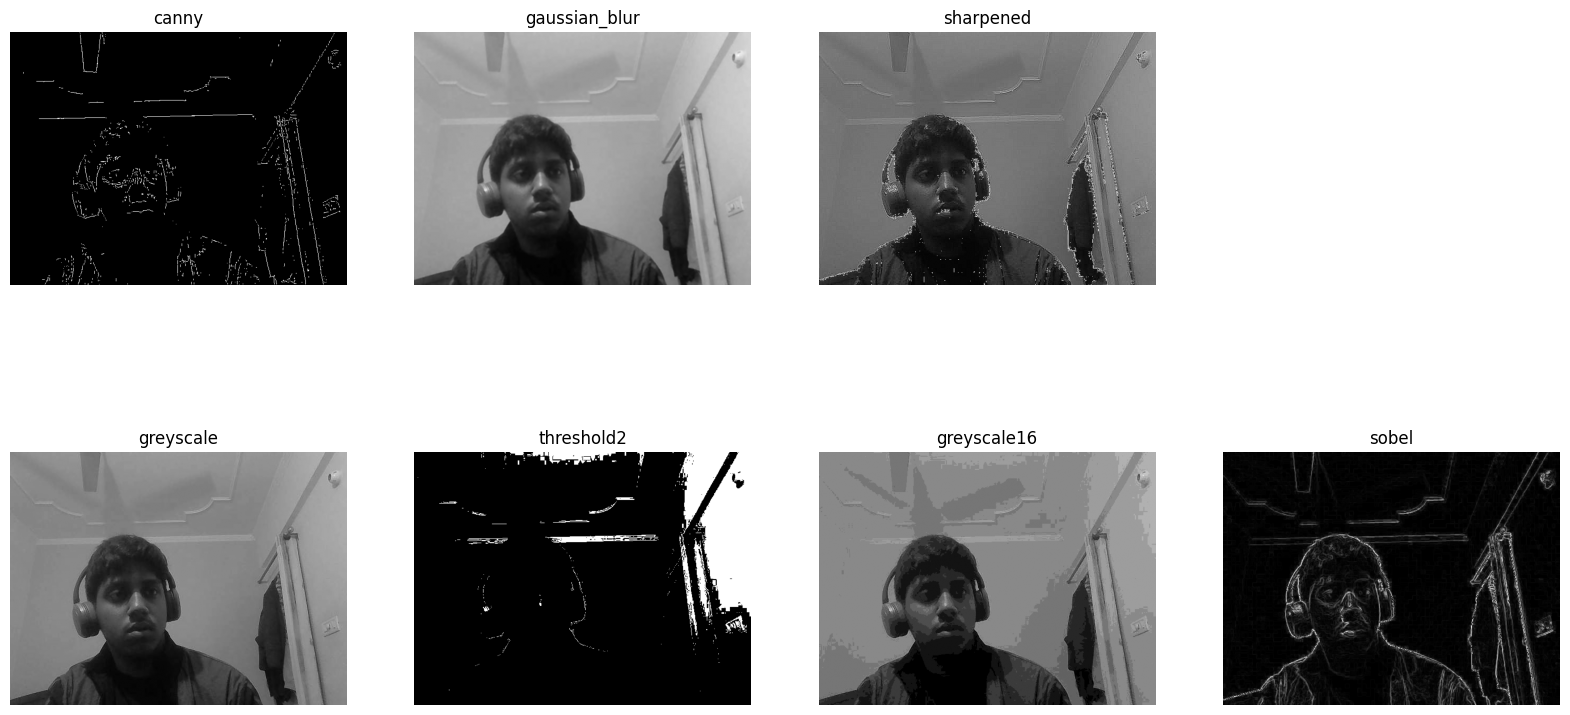

In [452]:
fig = plt.figure(figsize=(20, 20))
show(grey, 1,4,1, "greyscale")
show(grey2, 1,4,2, "threshold2")
show(grey16, 1,4,3, "greyscale16")
show(sobel, 1,4,4, "sobel")
show(canny, 2,4,1, "canny")
show(gaussian_blur, 2,4,2, "gaussian_blur")
show(sharpened, 2,4,3, "sharpened")

3.

In [494]:
img_0 = Image.open("mandrill.ppm")
img_1 = Image.open("lenna.jpg")
img_0 = img_0.convert('L')
img_1 = img_1.convert('L')
img_1 = img_1.resize(img_0.size)

img_arr_0 = np.array(img_0)
img_arr_1 = np.array(img_1)

blurred_img_0 = img_0.filter(ImageFilter.GaussianBlur(radius=5))
blurred_arr = np.array(blurred_img_0)
high_pass_array = img_arr_0 - blurred_arr

low_pass_array = np.array(img_1.filter(ImageFilter.GaussianBlur(radius=5)))

combined_array = low_pass_array + high_pass_array
combined_array = np.clip(combined_array, 0, 255)

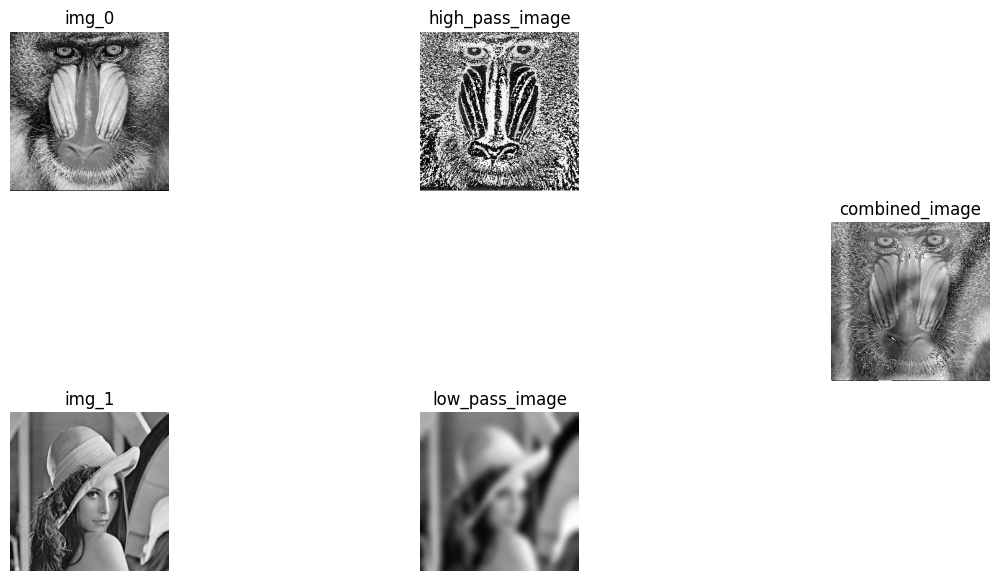

In [496]:
plt.figure(figsize=(15, 7))
show(img_arr_0, 3,3,1, "img_0")
show(img_arr_1, 3,3,7, "img_1")
show(high_pass_array, 3,3,2, "high_pass_image")
show(low_pass_array, 3,3,8, "low_pass_image")
show(combined_array, 3,3,6, "combined_image")


5.

In [534]:
def distinguish_flag(image_path):
    image = Image.open(image_path)
    image_array = np.array(image)
    height, width, _ = image_array.shape
    top_half = image_array[:height // 2, :, :]
    bottom_half = image_array[height // 2:, :, :]
    top_avg_color = np.mean(top_half, axis=(0, 1))
    bottom_avg_color = np.mean(bottom_half, axis=(0, 1))
    if top_avg_color[1] < bottom_avg_color[1] and top_avg_color[2] < bottom_avg_color[2] : return "Indonesia Flag"
    else : return "Polish Flag"


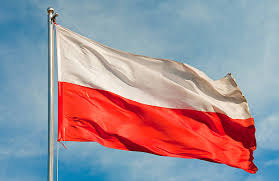

In [544]:
img = Image.open("polish_flag_1.jpg")
img

In [545]:
distinguish_flag("polish_flag_1.jpg")

'Polish Flag'

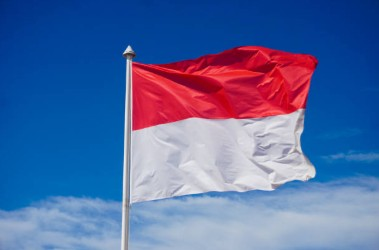

In [547]:
img = Image.open("indonesia_flag_1.jpg")
img

In [536]:
distinguish_flag("indonesia_flag_1.jpg")

'Indonesia Flag'

In [537]:
test = Image.open("indonesia_flag_1.jpg")
arr = np.array(test)
h, w, _ = arr.shape
top_half = arr[:h // 2, :, :]
bottom_half = arr[h // 2:, :, :]
print(np.mean(top_half, axis=(0, 1)))
print(np.mean(bottom_half, axis=(0, 1)))

[ 54.72455937  60.42672296 128.23691821]
[115.0302058  154.04848549 194.27221108]
